In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 50
CSV_FILE_PATH = 'gyroscope_data.csv'

def alineData(df):
    def alineDateWithLabel(label, df):
        lable_data = df[df['activity_type'] == label]
        return lable_data[0:lable_data.shape[0] - lable_data.shape[0] % MEASUREMENTS_PER_SAMPLE]
    
    return pd.concat([alineDateWithLabel(label, df) for label in df['activity_type'].unique()])

df = alineData(pd.read_csv(CSV_FILE_PATH))
samples_number = df.shape[0] // MEASUREMENTS_PER_SAMPLE

def prepareTargets(df):
    df = df[df.columns[-1:len(df.columns)]]
    
    def prepareTarget(sample_index):
        sample_start_index = sample_index * MEASUREMENTS_PER_SAMPLE
        sample_end_index = (sample_index + 1) * MEASUREMENTS_PER_SAMPLE
        
        targets = df[sample_start_index:sample_end_index]['activity_type'].unique()
        
        if(targets.size > 1):
            raise ValueError('Sample can not have more then one target')
        
        return targets[0] 
    
    return LabelBinarizer().fit_transform(np.array([prepareTarget(index) for index in range(0, samples_number)]))

def prepareSamples(df):
    return df[df.columns[0:-1]].values.reshape((samples_number, MEASUREMENTS_PER_SAMPLE, 6))

samples = prepareSamples(df)
targets = prepareTargets(df)

print(samples.shape)
print(targets.shape)

(1260, 50, 6)
(1260, 3)


In [3]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [4]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(756, 50, 6)
(756, 3)
(252, 50, 6)
(252, 3)
(252, 50, 6)
(252, 3)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [6]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [7]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

history = model.fit(train_data,
                    train_labels,
                    epochs=1000,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 756 samples, validate on 252 samples
Epoch 1/1000
756/756 [==============================] - 0s 386us/step - loss: 0.3965 - acc: 0.3823 - val_loss: 0.3697 - val_acc: 0.3571
Epoch 2/1000
756/756 [==============================] - 0s 72us/step - loss: 0.3855 - acc: 0.3955 - val_loss: 0.3512 - val_acc: 0.4206
Epoch 3/1000
756/756 [==============================] - 0s 75us/step - loss: 0.3586 - acc: 0.4312 - val_loss: 0.2885 - val_acc: 0.5119
Epoch 4/1000
756/756 [==============================] - 0s 76us/step - loss: 0.3372 - acc: 0.4616 - val_loss: 0.2110 - val_acc: 0.6587
Epoch 5/1000
756/756 [==============================] - 0s 85us/step - loss: 0.3158 - acc: 0.5013 - val_loss: 0.2294 - val_acc: 0.6349
Epoch 6/1000
756/756 [==============================] - 0s 84us/step - loss: 0.3054 - acc: 0.5119 - val_loss: 0.2183 - val_acc: 0.6468
Epoch 7/1000
756/756 [==============================] - 0s 80us/step - loss: 0.2950 - acc: 0.5304 - val_loss: 0.2152 - val_acc: 0.6587
Epoch 8/

Epoch 61/1000
756/756 [==============================] - 0s 72us/step - loss: 0.1378 - acc: 0.7632 - val_loss: 0.1344 - val_acc: 0.7817
Epoch 62/1000
756/756 [==============================] - 0s 74us/step - loss: 0.1354 - acc: 0.7765 - val_loss: 0.1328 - val_acc: 0.7897
Epoch 63/1000
756/756 [==============================] - 0s 73us/step - loss: 0.1455 - acc: 0.7460 - val_loss: 0.1387 - val_acc: 0.7500
Epoch 64/1000
756/756 [==============================] - 0s 75us/step - loss: 0.1257 - acc: 0.7910 - val_loss: 0.1217 - val_acc: 0.7778
Epoch 65/1000
756/756 [==============================] - 0s 80us/step - loss: 0.1258 - acc: 0.7725 - val_loss: 0.1122 - val_acc: 0.7897
Epoch 66/1000
756/756 [==============================] - 0s 67us/step - loss: 0.1236 - acc: 0.7712 - val_loss: 0.1043 - val_acc: 0.7976
Epoch 67/1000
756/756 [==============================] - 0s 67us/step - loss: 0.1171 - acc: 0.7791 - val_loss: 0.1039 - val_acc: 0.8056
Epoch 68/1000
756/756 [=========================

756/756 [==============================] - 0s 70us/step - loss: 0.0538 - acc: 0.8942 - val_loss: 0.0595 - val_acc: 0.8889
Epoch 122/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0524 - acc: 0.9074 - val_loss: 0.0585 - val_acc: 0.8810
Epoch 123/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0536 - acc: 0.9034 - val_loss: 0.0565 - val_acc: 0.8929
Epoch 124/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0608 - acc: 0.8836 - val_loss: 0.0524 - val_acc: 0.9048
Epoch 125/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0600 - acc: 0.9008 - val_loss: 0.0580 - val_acc: 0.8810
Epoch 126/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0528 - acc: 0.9048 - val_loss: 0.0572 - val_acc: 0.8889
Epoch 127/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0489 - acc: 0.9140 - val_loss: 0.0561 - val_acc: 0.8889
Epoch 128/1000
756/756 [==============================] 

Epoch 181/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0384 - acc: 0.9365 - val_loss: 0.0441 - val_acc: 0.9167
Epoch 182/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0365 - acc: 0.9378 - val_loss: 0.0399 - val_acc: 0.9206
Epoch 183/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0315 - acc: 0.9392 - val_loss: 0.0436 - val_acc: 0.9167
Epoch 184/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0385 - acc: 0.9233 - val_loss: 0.0463 - val_acc: 0.9008
Epoch 185/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0385 - acc: 0.9286 - val_loss: 0.0516 - val_acc: 0.9087
Epoch 186/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0316 - acc: 0.9444 - val_loss: 0.0476 - val_acc: 0.9206
Epoch 187/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0314 - acc: 0.9484 - val_loss: 0.0427 - val_acc: 0.9167
Epoch 188/1000
756/756 [=================

Epoch 241/1000
756/756 [==============================] - 0s 100us/step - loss: 0.0249 - acc: 0.9524 - val_loss: 0.0375 - val_acc: 0.9246
Epoch 242/1000
756/756 [==============================] - 0s 84us/step - loss: 0.0244 - acc: 0.9550 - val_loss: 0.0342 - val_acc: 0.9286
Epoch 243/1000
756/756 [==============================] - 0s 73us/step - loss: 0.0260 - acc: 0.9484 - val_loss: 0.0317 - val_acc: 0.9444
Epoch 244/1000
756/756 [==============================] - 0s 80us/step - loss: 0.0236 - acc: 0.9563 - val_loss: 0.0302 - val_acc: 0.9524
Epoch 245/1000
756/756 [==============================] - 0s 76us/step - loss: 0.0275 - acc: 0.9471 - val_loss: 0.0302 - val_acc: 0.9524
Epoch 246/1000
756/756 [==============================] - 0s 77us/step - loss: 0.0285 - acc: 0.9484 - val_loss: 0.0335 - val_acc: 0.9365
Epoch 247/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0209 - acc: 0.9630 - val_loss: 0.0313 - val_acc: 0.9405
Epoch 248/1000
756/756 [================

Epoch 301/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0247 - acc: 0.9590 - val_loss: 0.0318 - val_acc: 0.9484
Epoch 302/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0187 - acc: 0.9669 - val_loss: 0.0261 - val_acc: 0.9563
Epoch 303/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0192 - acc: 0.9643 - val_loss: 0.0300 - val_acc: 0.9484
Epoch 304/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0165 - acc: 0.9683 - val_loss: 0.0333 - val_acc: 0.9405
Epoch 305/1000
756/756 [==============================] - 0s 71us/step - loss: 0.0198 - acc: 0.9722 - val_loss: 0.0280 - val_acc: 0.9563
Epoch 306/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0165 - acc: 0.9696 - val_loss: 0.0234 - val_acc: 0.9603
Epoch 307/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0182 - acc: 0.9656 - val_loss: 0.0267 - val_acc: 0.9524
Epoch 308/1000
756/756 [=================

Epoch 361/1000
756/756 [==============================] - 0s 69us/step - loss: 0.0127 - acc: 0.9762 - val_loss: 0.0328 - val_acc: 0.9405
Epoch 362/1000
756/756 [==============================] - 0s 71us/step - loss: 0.0120 - acc: 0.9775 - val_loss: 0.0320 - val_acc: 0.9484
Epoch 363/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0189 - acc: 0.9656 - val_loss: 0.0261 - val_acc: 0.9524
Epoch 364/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0172 - acc: 0.9656 - val_loss: 0.0295 - val_acc: 0.9524
Epoch 365/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0171 - acc: 0.9735 - val_loss: 0.0345 - val_acc: 0.9405
Epoch 366/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0133 - acc: 0.9775 - val_loss: 0.0308 - val_acc: 0.9444
Epoch 367/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0204 - acc: 0.9630 - val_loss: 0.0321 - val_acc: 0.9444
Epoch 368/1000
756/756 [=================

Epoch 421/1000
756/756 [==============================] - 0s 81us/step - loss: 0.0125 - acc: 0.9788 - val_loss: 0.0287 - val_acc: 0.9603
Epoch 422/1000
756/756 [==============================] - 0s 86us/step - loss: 0.0092 - acc: 0.9802 - val_loss: 0.0331 - val_acc: 0.9365
Epoch 423/1000
756/756 [==============================] - 0s 80us/step - loss: 0.0130 - acc: 0.9802 - val_loss: 0.0314 - val_acc: 0.9484
Epoch 424/1000
756/756 [==============================] - 0s 75us/step - loss: 0.0125 - acc: 0.9762 - val_loss: 0.0321 - val_acc: 0.9444
Epoch 425/1000
756/756 [==============================] - 0s 74us/step - loss: 0.0062 - acc: 0.9881 - val_loss: 0.0361 - val_acc: 0.9444
Epoch 426/1000
756/756 [==============================] - 0s 69us/step - loss: 0.0076 - acc: 0.9854 - val_loss: 0.0307 - val_acc: 0.9484
Epoch 427/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0135 - acc: 0.9775 - val_loss: 0.0283 - val_acc: 0.9524
Epoch 428/1000
756/756 [=================

Epoch 481/1000
756/756 [==============================] - 0s 75us/step - loss: 0.0117 - acc: 0.9788 - val_loss: 0.0245 - val_acc: 0.9563
Epoch 482/1000
756/756 [==============================] - 0s 78us/step - loss: 0.0112 - acc: 0.9815 - val_loss: 0.0284 - val_acc: 0.9484
Epoch 483/1000
756/756 [==============================] - 0s 75us/step - loss: 0.0133 - acc: 0.9775 - val_loss: 0.0268 - val_acc: 0.9603
Epoch 484/1000
756/756 [==============================] - 0s 82us/step - loss: 0.0167 - acc: 0.9696 - val_loss: 0.0267 - val_acc: 0.9524
Epoch 485/1000
756/756 [==============================] - 0s 129us/step - loss: 0.0111 - acc: 0.9802 - val_loss: 0.0243 - val_acc: 0.9643
Epoch 486/1000
756/756 [==============================] - 0s 83us/step - loss: 0.0125 - acc: 0.9762 - val_loss: 0.0248 - val_acc: 0.9563
Epoch 487/1000
756/756 [==============================] - 0s 76us/step - loss: 0.0136 - acc: 0.9735 - val_loss: 0.0229 - val_acc: 0.9683
Epoch 488/1000
756/756 [================

Epoch 541/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0108 - acc: 0.9815 - val_loss: 0.0295 - val_acc: 0.9524
Epoch 542/1000
756/756 [==============================] - 0s 63us/step - loss: 0.0109 - acc: 0.9828 - val_loss: 0.0257 - val_acc: 0.9603
Epoch 543/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0048 - acc: 0.9921 - val_loss: 0.0289 - val_acc: 0.9524
Epoch 544/1000
756/756 [==============================] - 0s 69us/step - loss: 0.0084 - acc: 0.9841 - val_loss: 0.0317 - val_acc: 0.9405
Epoch 545/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0085 - acc: 0.9841 - val_loss: 0.0271 - val_acc: 0.9563
Epoch 546/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0107 - acc: 0.9762 - val_loss: 0.0294 - val_acc: 0.9563
Epoch 547/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0083 - acc: 0.9854 - val_loss: 0.0255 - val_acc: 0.9603
Epoch 548/1000
756/756 [=================

Epoch 601/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0084 - acc: 0.9841 - val_loss: 0.0269 - val_acc: 0.9563
Epoch 602/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0081 - acc: 0.9854 - val_loss: 0.0283 - val_acc: 0.9524
Epoch 603/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0066 - acc: 0.9868 - val_loss: 0.0305 - val_acc: 0.9484
Epoch 604/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0127 - acc: 0.9762 - val_loss: 0.0329 - val_acc: 0.9484
Epoch 605/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0096 - acc: 0.9841 - val_loss: 0.0259 - val_acc: 0.9603
Epoch 606/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0077 - acc: 0.9841 - val_loss: 0.0352 - val_acc: 0.9405
Epoch 607/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0082 - acc: 0.9868 - val_loss: 0.0247 - val_acc: 0.9563
Epoch 608/1000
756/756 [=================

Epoch 661/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0118 - acc: 0.9762 - val_loss: 0.0273 - val_acc: 0.9524
Epoch 662/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0080 - acc: 0.9841 - val_loss: 0.0325 - val_acc: 0.9444
Epoch 663/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0100 - acc: 0.9815 - val_loss: 0.0286 - val_acc: 0.9484
Epoch 664/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0064 - acc: 0.9881 - val_loss: 0.0242 - val_acc: 0.9563
Epoch 665/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0066 - acc: 0.9868 - val_loss: 0.0251 - val_acc: 0.9563
Epoch 666/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0038 - acc: 0.9921 - val_loss: 0.0226 - val_acc: 0.9603
Epoch 667/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0083 - acc: 0.9828 - val_loss: 0.0241 - val_acc: 0.9563
Epoch 668/1000
756/756 [=================

Epoch 721/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0060 - acc: 0.9894 - val_loss: 0.0341 - val_acc: 0.9444
Epoch 722/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0049 - acc: 0.9907 - val_loss: 0.0355 - val_acc: 0.9405
Epoch 723/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0059 - acc: 0.9894 - val_loss: 0.0339 - val_acc: 0.9484
Epoch 724/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0061 - acc: 0.9881 - val_loss: 0.0324 - val_acc: 0.9484
Epoch 725/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0083 - acc: 0.9841 - val_loss: 0.0376 - val_acc: 0.9405
Epoch 726/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0048 - acc: 0.9921 - val_loss: 0.0350 - val_acc: 0.9405
Epoch 727/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0098 - acc: 0.9788 - val_loss: 0.0275 - val_acc: 0.9524
Epoch 728/1000
756/756 [=================

Epoch 781/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0081 - acc: 0.9841 - val_loss: 0.0351 - val_acc: 0.9405
Epoch 782/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0046 - acc: 0.9907 - val_loss: 0.0334 - val_acc: 0.9444
Epoch 783/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0059 - acc: 0.9907 - val_loss: 0.0364 - val_acc: 0.9405
Epoch 784/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0075 - acc: 0.9868 - val_loss: 0.0322 - val_acc: 0.9524
Epoch 785/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0082 - acc: 0.9841 - val_loss: 0.0301 - val_acc: 0.9524
Epoch 786/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0045 - acc: 0.9921 - val_loss: 0.0268 - val_acc: 0.9524
Epoch 787/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0047 - acc: 0.9907 - val_loss: 0.0292 - val_acc: 0.9524
Epoch 788/1000
756/756 [=================

Epoch 841/1000
756/756 [==============================] - 0s 77us/step - loss: 0.0101 - acc: 0.9828 - val_loss: 0.0314 - val_acc: 0.9524
Epoch 842/1000
756/756 [==============================] - 0s 79us/step - loss: 0.0024 - acc: 0.9960 - val_loss: 0.0313 - val_acc: 0.9444
Epoch 843/1000
756/756 [==============================] - 0s 75us/step - loss: 0.0079 - acc: 0.9868 - val_loss: 0.0320 - val_acc: 0.9444
Epoch 844/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0079 - acc: 0.9841 - val_loss: 0.0373 - val_acc: 0.9405
Epoch 845/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0050 - acc: 0.9921 - val_loss: 0.0390 - val_acc: 0.9365
Epoch 846/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0036 - acc: 0.9934 - val_loss: 0.0351 - val_acc: 0.9444
Epoch 847/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0031 - acc: 0.9960 - val_loss: 0.0311 - val_acc: 0.9484
Epoch 848/1000
756/756 [=================

Epoch 901/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0084 - acc: 0.9854 - val_loss: 0.0265 - val_acc: 0.9563
Epoch 902/1000
756/756 [==============================] - 0s 70us/step - loss: 0.0046 - acc: 0.9907 - val_loss: 0.0292 - val_acc: 0.9524
Epoch 903/1000
756/756 [==============================] - 0s 65us/step - loss: 0.0043 - acc: 0.9921 - val_loss: 0.0310 - val_acc: 0.9484
Epoch 904/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0073 - acc: 0.9854 - val_loss: 0.0310 - val_acc: 0.9484
Epoch 905/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0056 - acc: 0.9907 - val_loss: 0.0297 - val_acc: 0.9484
Epoch 906/1000
756/756 [==============================] - 0s 64us/step - loss: 0.0043 - acc: 0.9934 - val_loss: 0.0262 - val_acc: 0.9563
Epoch 907/1000
756/756 [==============================] - 0s 67us/step - loss: 0.0062 - acc: 0.9894 - val_loss: 0.0290 - val_acc: 0.9563
Epoch 908/1000
756/756 [=================

756/756 [==============================] - 0s 64us/step - loss: 0.0088 - acc: 0.9854 - val_loss: 0.0281 - val_acc: 0.9524
Epoch 961/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0067 - acc: 0.9868 - val_loss: 0.0297 - val_acc: 0.9524
Epoch 962/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0077 - acc: 0.9854 - val_loss: 0.0334 - val_acc: 0.9444
Epoch 963/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0064 - acc: 0.9868 - val_loss: 0.0320 - val_acc: 0.9484
Epoch 964/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0063 - acc: 0.9894 - val_loss: 0.0319 - val_acc: 0.9444
Epoch 965/1000
756/756 [==============================] - 0s 68us/step - loss: 0.0043 - acc: 0.9934 - val_loss: 0.0291 - val_acc: 0.9563
Epoch 966/1000
756/756 [==============================] - 0s 66us/step - loss: 0.0066 - acc: 0.9894 - val_loss: 0.0303 - val_acc: 0.9484
Epoch 967/1000
756/756 [==============================] 

               acc      val_acc         loss     val_loss
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.948737     0.925274     0.029300     0.043649
std       0.084612     0.065616     0.051509     0.039600
min       0.382275     0.357143     0.001395     0.017637
25%       0.957672     0.935516     0.006898     0.028506
50%       0.980159     0.948413     0.010871     0.031682
75%       0.988095     0.952381     0.023397     0.036708
max       0.998677     0.972222     0.396533     0.369736


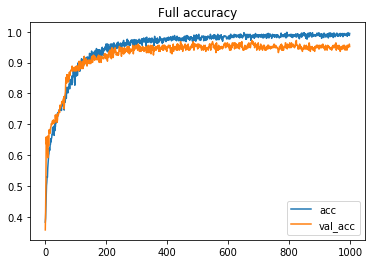

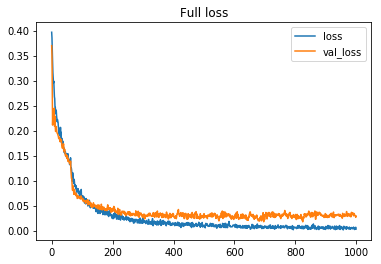

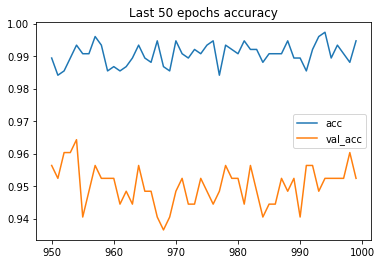

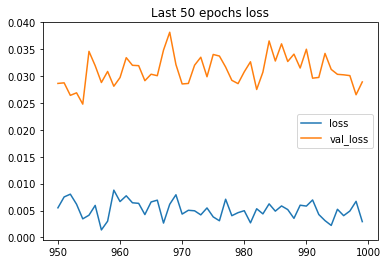

In [8]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [9]:
best_model = keras.models.load_model('models/best_model.hdf5')

In [10]:
best_model.evaluate(test_data, test_labels)

252/252 [==============================] - 0s 219us/step


[0.010254761694093466, 0.9801587301587301]

In [25]:
best_model.predict(test_data[0:1])

array([[9.9999702e-01, 2.3807513e-06, 5.5663725e-07]], dtype=float32)